In [47]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import pdist,squareform

# Data

In [2]:
ratings = pd.read_excel('rating.xlsx')

In [3]:
ratings.describe()

,userId,movieId,rating,timestamp
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,3.527086e+03,8.648988e+03,3.529272e+00,1.096036e+09
std,2.018424e+03,1.910014e+04,1.051919e+00,1.594899e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,8.254999e+08
25%,1.813000e+03,9.030000e+02,3.000000e+00,9.658382e+08
50%,3.540000e+03,2.143000e+03,4.000000e+00,1.099263e+09
75%,5.233000e+03,4.641000e+03,4.000000e+00,1.217407e+09
max,7.120000e+03,1.306420e+05,5.000000e+00,1.427764e+09


Text(0, 0.5, 'Number of views')

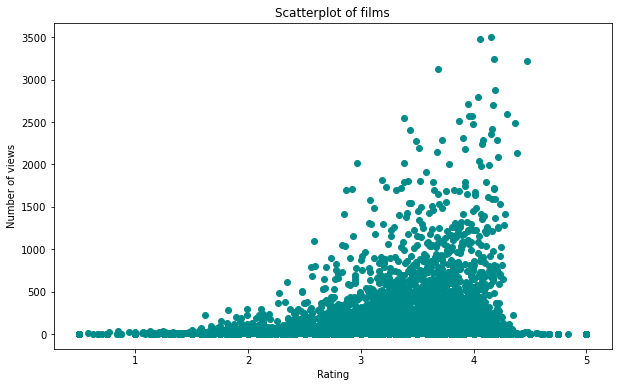

In [4]:
#Inventing features for analysis
N_views = ratings.groupby(ratings.movieId).count().iloc[:,[0]]
average_rating = ratings.groupby(ratings.movieId).mean().iloc[:,[1]]
data_for_analysis = pd.DataFrame({'N_views':N_views.userId, 'Rating':average_rating.rating})


plt.figure(figsize = (10,6))
plt.scatter(data_for_analysis['Rating'],data_for_analysis['N_views'],c ='darkcyan')
plt.title('Scatterplot of films')
plt.xlabel('Rating')
plt.ylabel('Number of views')

# Clustering

In [5]:
C_data = data_for_analysis.copy()

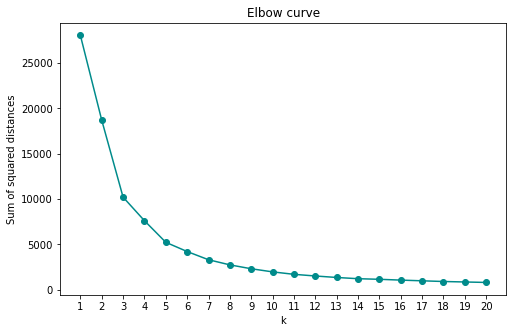

In [6]:
#Clustering k-means
X = StandardScaler().fit_transform(data_for_analysis)
X = np.array(X)

#Elbow curve
Sum_of_squared_distances = []

K = range(1,21)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize = (8,5))
plt.plot(K,Sum_of_squared_distances,'o-',color = 'darkcyan')   
plt.title('Elbow curve')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

In [7]:
n = 7 #number of clusters

km = KMeans(n_clusters=n, init='k-means++').fit(X)
labels = km.labels_
C_data['k-means'] = labels+1

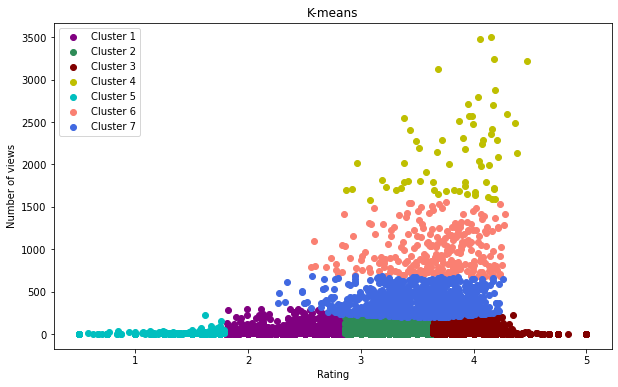

In [8]:
#vizualization

plt.figure(figsize =(10,6))
c = ['purple', 'seagreen','maroon','y','c','salmon','royalblue','r','black','blue']
cl = C_data['k-means'].unique()

for i in sorted(cl):
    ff = C_data[C_data['k-means'] == i]
    plt.scatter(ff['Rating'],ff['N_views'],color = c[i-1],label = 'Cluster '+str(i))
    plt.title('K-means')
    plt.ylabel('Number of views')
    plt.xlabel('Rating')
    plt.legend(loc = 2)

In [9]:
# N of elementes ineach Cluster
C_data.groupby(C_data['k-means']).count()

,N_views,Rating
k-means,,
1,2717,2717
2,5489,5489
3,3799,3799
4,64,64
5,803,803
6,260,260
7,894,894


# Outlier Detection

## DBSCAN

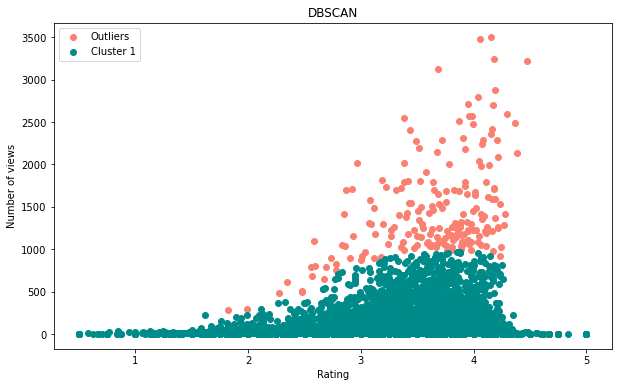

In [10]:
#DBSCAN

dbscan = DBSCAN(min_samples = 50,eps = 0.5).fit(X)
C_data['dbscan'] = dbscan.labels_
c = ['salmon','darkcyan','purple', 'seagreen','maroon','y','c','royalblue','r','black','blue']


plt.figure(figsize =(10,6))
for i in sorted(C_data['dbscan'].unique()):
    ff = C_data[C_data['dbscan'] == i]
    plt.scatter(ff['Rating'],ff['N_views'],color = c[int(i+1)])
    plt.title('DBSCAN')
    plt.ylabel('Number of views')
    plt.xlabel('Rating')
    plt.legend(('Outliers', 'Cluster 1','Cluster 2'),loc =2)

In [11]:
C_data.groupby(C_data['dbscan']).count()

,N_views,Rating,k-means
dbscan,,,
-1,203,203,203
0,13823,13823,13823


## Knn

In [12]:
Xknn = np.array(X)
k = 50 #N of nearest neighbors
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Xknn)
distances, indices = nbrs.kneighbors(Xknn)
max_dist =  distances.max(axis = 1)


threshold_rate = 0.03
N = round(len(max_dist) * threshold_rate)

max_dist_sn_max = sorted(max_dist, reverse = True)[:N]
threshold = min(max_dist_sn_max)

outlier = []
for i in distances:
    g = i[np.where( i > threshold)]
    if len(g)>0:
        outlier.append(1)
    else:
        outlier.append(0)

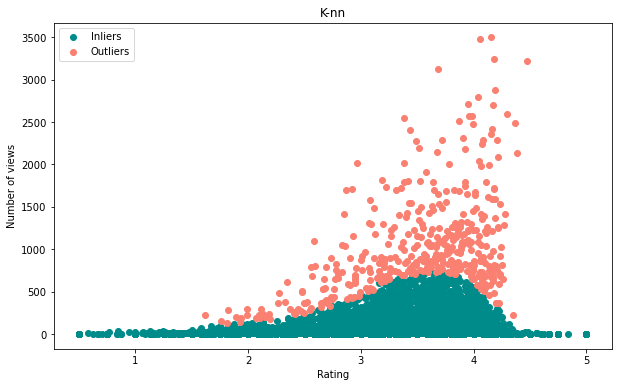

In [13]:
#vizualization
plt.figure(figsize =(10,6))
C_data['knn'] = outlier
c = ['purple','darkcyan','salmon','maroon','y','seagreen','royalblue','r','black','blue']

for i in sorted(C_data['knn'].unique()):
    ff = C_data[C_data['knn'] == i]
    plt.scatter(ff['Rating'],ff['N_views'],color = c[int(i+1)])
    plt.title('K-nn')
    plt.ylabel('Number of views')
    plt.xlabel('Rating')
    plt.legend(('Inliers','Outliers'),loc =2)

In [14]:
C_data.groupby(C_data['knn']).count()

,N_views,Rating,k-means,dbscan
knn,,,,
0,13606,13606,13606,13606
1,420,420,420,420


## Outliers

In [53]:
knn_outliers = C_data[C_data['knn']==1].index
dbscan_outliers = C_data[C_data['dbscan']==-1].index
kmean_outliers =  C_data[C_data['k-means'].isin([4,6])].index

# Map matrix with Genres

In [37]:
movies_db = pd.read_excel('movies.xlsx').set_index('movieId')

In [38]:
#Choose movies with existing rating
movies = movies_db.loc[C_data.index,]

In [39]:
# Split Title and Year
movies_split = movies.title.str.split('(', expand = True)
movies_split[1] = movies_split[1].str.replace(')','')

movies['year'] = movies_split[1]
movies['title'] = movies_split[0]

In [40]:
#unique genre
genre=[]
for i in list(movies.genres):
    gg = str(i).split('|')
    for j in gg:
        if j not in genre:
            genre.append(j)
genre = genre[:-2]


#map matrix with Genres
def GENRE(genre,list_movies):
    list_genre = []
    for i in list_movies:
        gg = str(i).split('|')
        if genre in gg:
            list_genre.append(1)
        else:
            list_genre.append(0)
    return list_genre


for i in genre:
    movies[str(i)] = GENRE(i,list(movies.genres))